<h1 align="center" style="color:blue;font-size: 3em;" >Sentiment Analysis of Amazon Reviews using Transformers</h1>

## This program is broken down into 3 sections:

**1. We will work on data cleaning and preprocessing.**

**2. We will then work on creating the sentiment analyzer and train it on the data we have preprocessed.**

**3. Finally, we will evauate our model and visualize the results.**

***Heads Up: Some of the cells might not have an output after they finish running. This is completely normal. You can always hover over the play button you click to run them and it will let you know if the cell has been executed and how long the process took. If there ever is an error, the cell will print out the stack trace and the issue it encountered.***

## Let us begin by importing the necessary libraries

***Heads Up: You might see a warning when importing the packages, but you may ignore this, as it won't cause any issues for our needs.***

In [1]:
# For viewing and manipulating data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing the necessary libraries
import re
import math
import string
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
from gensim.models import KeyedVectors # >> alternative to gensim.downloader
import matplotlib.pyplot as plt

# Getting particular functions from these libraries 
from torch import Tensor
from sklearn.utils import resample
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset

# Using the NLTK to tokenize the text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
reviews_file = ''
w2v_file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_name = os.path.join(dirname, filename)
        if file_name.endswith('.csv'): 
            reviews_file = file_name
        elif file_name.endswith('.bin'):
            w2v_file = file_name
        else:
            print(f'Found unexpected file: {file_name}')
                
print(f'Amazon reviews file: {reviews_file}')
print(f'Google news word to vec file: {w2v_file}')
            

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
VERBOSE = True
def printv(text):
    if VERBOSE: print('VERBOSE:', text)
    return

def showV(text):
    '''unconditional verbose output'''
    print('VERBOSE:', text)
    return

DEV = True
def printd(text):
    if DEV: print('DEV:', text)
    return

def showD(text):
    '''unconditional DEV output'''
    print('VERBOSE:', text)
    return

showCellCompletion = True
def showC(text):
    if showCellCompletion:
        print('Cell complete:', text)
    return

import subprocess
showNv = True
accelerator = False

def printNv():
    if not showNv or not accelerator: return
    mem_usage = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(mem_usage.stdout.decode('utf-8'))

showMemoryAllocation = True
def printM():
    if not showMemoryAllocation: return
    print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
    

Amazon reviews file: /kaggle/input/amazon-product-reviews/Reviews.csv
Google news word to vec file: /kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin


**This magic command we are running below gives the notebook access to parts of the NLTK library. When ran correctly, it should unzip the wordnet file and copy over its contents.**

**Please only run this command once when you start the notebook. If you run it again, it will prompt you to replace the existing files. After you run it once, you may comment it out. If you happen to run it again, and you are prompted for a response, simply stop the cell and move on to the next section.** 


In [2]:
## Only run once
#>> Seems to need to be rerun after every Kaggle timeout.
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Section 1: Data Cleaning and Preprocessing

**One thing you will hear often when working with data is that preprocessing is the most important part. If the data is not cleaned and prepared for the model, you will always get sub-par results.**

**The image below illustrate our goals for this section. It may look confusing now, but things will be clearer as we go through the section.**

**For this project, we will be using over 568,000 reviews collected from Amazon. The cell below the image contains the code that will give us access to the dataset. You can also find the dataset linked here.**

(Note that a word embedding is a representation of a word in an n-dimensonal vector space, n ≥ 2)

[Amazon Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)

![Example of Embeddings](https://www.researchgate.net/publication/340825443/figure/fig6/AS:882927785238529@1587517796128/Word-embeddings-map-words-in-a-corpus-of-text-to-vector-space-Linear-combinations-of.png)

* Source: [Word embeddings map words in a corpus of text to vector space](https://figshare.com/articles/figure/Word_embeddings_map_words_in_a_corpus_of_text_to_vector_space_/12169047/1)

**Let's access the dataset and see how many reviews we actually have.**

In [3]:
# Load data from CSV
#>>  3/13 needed to change the path as below
# path ='/kaggle/input/Reviews.csv'#"/kaggle/input/amazon-product-reviews/Reviews.csv"
data = pd.read_csv(reviews_file) # Use pandas to analyze data
showD('Amazon reviews loaded into Panda')

VERBOSE: Amazon reviews loaded into Panda


**We can use the pandas object methods and fields to explore the Amazon reviews.**

In [4]:
# print number of rows in our ratings column
printv(f'Number of reviews: {len(data["Score"])}')
printv(f'Column names -\n {data.columns}\n') 
printv(f'First five rows -\n{data.head()}')

VERBOSE: Number of reviews: 568454
VERBOSE: Column names -
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

VERBOSE: First five rows -
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                     

**The data has 1O columns, including "Score," indicating the review's sentiment, and "Text," the product review the score is based on. In Machine Learning, Text would be called the FEATURE, the term for the column(s) used for inference.**


**There is far too much data to print, but we can print the total number of reviews per rating and use the functions provided to us by matplotlib to visualize the distribution as a bar graph.**

52,268 samples from balanced data with rating 1

29,769 samples from balanced data with rating 2

42,640 samples from balanced data with rating 3

80,655 samples from balanced data with rating 4

363,122 samples from balanced data with rating 5



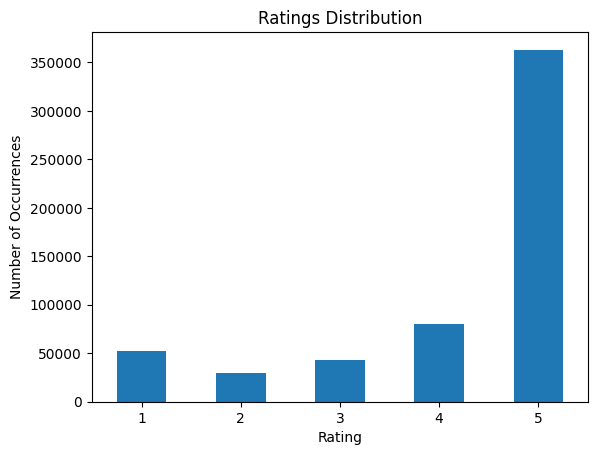

In [5]:
# Get count of ratings 
rating_counts = data['Score'].value_counts()

# Sort counts by index ascending
rating_counts = rating_counts.sort_index()  

# Print number of reviews per rating
#for rating, count in rating_counts.items():
#    print(f"{count:,} reviews with a rating score of {rating}", "\n")

# Get count of ratings
#>> Seems to work even if we do not redefine rating_count
#>> rating_counts = data['Score'].value_counts().sort_index() 

# Create bar plot
ax = rating_counts.plot(kind = 'bar')

ax.set_title("Ratings Distribution")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Occurrences")

# Fix x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0) 

for rating, count in rating_counts.items():
        print(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show() #<< show the rating in each of the 5 categories

**The distribution is heavily skewed to the positive side, with 5 star reviews making up more than half of our dataset. While that's great for Amazon and its customers, it could bias our model and starve it of adequate negative and neutral reviews to train on.**

**To work around this we balance the data. 29,769 reviewers gave products a 2, the fewest for any rating, so that is the maximum numbers of reviews we can use in each category.  Fret not, that is still a vast amount of data to work with, but we may need to reduce it even futher during development to reduce the processing load.**

In [6]:
balanced_data_size = 1000 #<< number of reviews in each rating category, tailored for CPU capacity
# Specify the column for sorting and balancing
sort_column = 'Score'  # This is one the rating column

# Sort the data by the rating values
sorted_data = data.sort_values(by = sort_column)

# Create a balanced dataset with 25,000 samples from each class
#balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n=25000))

#>> DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. 
#>> This behavior is deprecated, and in a future version of pandas the grouping 
#>> columns will be excluded from the operation. 
#>> Either pass `include_groups=False` to exclude the groupings or 
#>> explicitly select the grouping columns after groupby to silence this warning.
#
balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n = balanced_data_size))

#>> Does this mean to reset the row numbers?? ##Columns Numbers
balanced_data.reset_index(drop = True, inplace = True)

printv(f"The number of reviews equally distributed across all ratings is {len(balanced_data['Score'])}")

VERBOSE: The number of reviews equally distributed across all ratings is 5000


/tmp/ipykernel_33/1260224495.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n = balanced_data_size))


**We can use matplotlib to see that reviews are equally distributed across all rating categories in the balanced data.**

1,000 samples from balanced data with rating 1

1,000 samples from balanced data with rating 2

1,000 samples from balanced data with rating 3

1,000 samples from balanced data with rating 4

1,000 samples from balanced data with rating 5



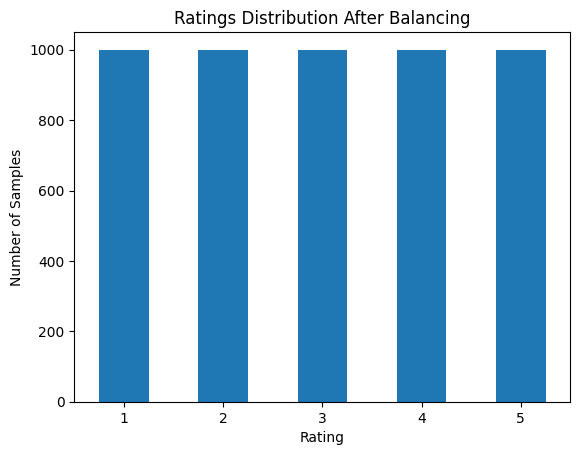

In [7]:
# Get count of ratings
rating_counts = balanced_data['Score'].value_counts()

# Create bar plot
ax = rating_counts.plot(kind='bar')

ax.set_title("Ratings Distribution After Balancing")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Samples")

# Fix x-axis ticks  
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

# Print number of reviews per rating

if DEV:
    for rating, count in rating_counts.items():
        print(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show()

**That looks much better. We see that each rating class is sufficiently represented, and we can expect to get a more well-rounded analyzer. While this is a good way to even things out, our model can still be biased due to the reviews themselves. People leave comments when they have stronger opinions about a product. This is why balancing the types of reviews we give our model is necessary, so that the model can get a complete representation of the range of opinions**

**We will also encounter things like typos, improper punctuation and spacing, along with other grammatical issues. While we will leave the dataset as is for now, it is important to try other approaches to identify these issues and filter them out.**

**Now that we have our dataset ready, let's get to work on preprocessing it. Our reviews contain things like punctuations that we don't need to work with. To get rid of these, we use regular expressions to filter them out, and convert every character to lowercase to achieve uniformity.**

**Something else we can do is a process called Lemmatization. This is the process of replacing variants of a word by the base word itself. An example of this would be to change the words knew, knowing, and known to their base word: know. This will help us achieve better uniformity by avoiding the misplacement of a word's variants.** <span style="color:blue">Do you actually use the lemmatizer?

In [8]:
stop = stopwords.words('english') # Imported from nltk.corpus
lem = WordNetLemmatizer()         # Imported from nltk.stem

In [9]:
stop = sorted(stop) #it's easier to use if it's sorted
showD (f'{stop}\n')
# No need printd (f'{lem}\n')

# test lemmatizer
word = "dogs"
lemmatized_word = lem.lemmatize(word)
showD(f'The lemmatized version of "{word}" is "{lemmatized_word}".')

VERBOSE: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so'

**Let's create a function that takes our reviews and returns a lemmanized, lower-case, punctuation-free version of it.** **We can then store this new version in a new column called 'CleanedReview' for easy access.**

***Heads up: This cell takes a little longer to execute.***

In [10]:
# Takes some time to run
# >> 3/29/24 Took less than 15 seconds to run 

def tokenizer(text):
    """
    Tokenizes a text string and removes stop words.

    Args:
        text (str): The text string to tokenize.

    Returns:
        list: The tokenized text string.
    """
    text = text.lower()  # Convert text to lowercase.
    text = re.sub("<.*?>", "", text)  # Remove HTML tags.
    text = re.sub('[^\w\s\']+', "", text)  # Remove punctuation and symbols.
    # text = text.split('\n')  # Split text on new lines.
    
    #>> Have we decided not to use stop words?
    text = [lem.lemmatize(word) for word in text.split()]#if word not in stop]  # Remove stop words. 

    return text

# Apply the function to the Text column and store it in a new column
balanced_data['CleanedReview'] = balanced_data['Text'].apply(tokenizer)

# show that cell has finished executing
showC(f'{tokenizer} defined, and then used to create CleanedReview column')

Cell complete: <function tokenizer at 0x7b53c11c0ee0> defined, and then used to create CleanedReview column


**Another look at the data after the addition of the CleanedReview column.**

In [11]:
# Store the Rating column
rating = balanced_data['Score']  

# Store the CleanedReview column
tokenized_review = balanced_data['CleanedReview']
showD(f'specify the columns that will be used to train the classifier')

VERBOSE: specify the columns that will be used to train the classifier


**We can see that our data now has 11 columns, with the addition of CleanReview, and that the CleanedReview column is the product review mapped to a sequence of standardized words.**

**There are just a few more steps remaining before we can load the data. We have to tokenize the words from the reviews because neural networks, much like computers, don't really understand words. Instead, our tokenizer is going to associate every word with a number that can be used to look up the word's embeddings.**

**Think of embeddings as vector representations of the word in space.**

**There are many approaches we can take to vectorizing our reviews, so much so in fact that word embeddings are a big part of Natural Language Processing. Without getting too bogged down in details, some approaches use statistical approaches like bag-of-words to figure out context, and others can use neural network-based models that are trained to find features themselves.** 

**The quickest way would be to take an already trained tokenizer made for established transformer-based models. For example, the BertTokenizer is a tokenizer that was trained and used by BERT. BERT is a massive Transformer-based model created by Google in 2018. It was a significant achievement because it was able to perform up to 11 NLP tasks, including summarization, text-generation(think ChatGPT), and even sentiment analysis.**

**Word2vec-google-news-300 is a pre-trained deep-learning word embedding model that was trained on a massive dataset of 100 billion words from the Google News corpus. The model contains 300-dimensional vectors for 3 million words and phrases. That is what we will be using for this project**

**Word2Vec extracts both semantic and contextual representations of words. The semantic representation of a word captures the meaning of the word itself, while the contextual representation captures the meaning of the word in the context of the surrounding words.**

**To explain what's happening in the Word2Vec embedding process:**

1. **The tokenizer splits the raw text into tokens/words.**
2. **Word2Vec has IDs that serve as indices into a lookup table that stores the vector representations, meaning that each ID corresponds to a unique vector representation in the table.**
3. **For each token, we lookup the corresponding ID in the Word2Vec vocabulary using .key_to_index.**
4. **This maps the tokens to existing Word2Vec IDs.**
5. **We pass these IDs into the embedding layer.**
6. **The embedding layer has a 300-dim vector for each ID.**
7. **So each token gets replaced by its pre-trained 300-dim Word2Vec vector.**

**To summarize:**

* **Tokenizer splits text into words.**
* **Word2Vec vocab provides ID for each word.**
* **Embedding layer maps IDs to 300-dim vectors.**
* **So tokens are replaced by 300-dim pretrained embeddings.**

**Let's start by downloading our word2vec model and set a variable we will use to limit the number of out tokens per review to 100 tokens. We will later zero-pad these reviews so we can have a uniform number of tokens per review.**


***Heads up: This cell will take some time to execute.***

In [12]:
# >> 3/29/24 Took less than a minute to run without the accelerator.
# Load Word2Vec model
#w2v = api.load('word2vec-google-news-300')
w2v = KeyedVectors.load_word2vec_format (w2v_file, binary=True)

# Define the aimum sequence length (adjust as needed)
#>> Will increasing max_sequence_length impact performance?
max_sequence_length = 100

showD(f'{w2v} can map words onto vectors with 300 dimensions')

VERBOSE: KeyedVectors<vector_size=300, 3000000 keys> can map words onto vectors with 300 dimensions


**Now that we have downloaded our model, let's use our CUDA-enabled GPU to take our token and look for its corresponding vector from our model. Once we find it, we swap it out with the new vector and if we don't, we pad that token with zeros.**

In [13]:
# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")
    accelerator = True

else:
    accelerator = False
    print("CUDA is not available.")
    device = torch.device("cpu")
    print(device)

CUDA is not available.
cpu


**After ensuring that we have our GPUs available, we can go onto the next step. The code continues even if a CUDA is not available.**

**In the cell below, we will do the following:**

* **Create a new tensor and populate it with zeros**
* **Compare the length of our review to the maximum length we allow (100) and take the minimum of the two**
* **We lookup the token against what's in the w2v model. If we find it, we replace it with the embedding.**
* **If we can't find it, we leave it as is (zero vectors).**

***Heads Up: Cell below takes about 5 minutes to run***

In [14]:
#>> 3/29/24 Completed in less than 30 seconds using 1347 as max_sequence_length 

# Assume you have a list of tokenized review called tokenized_review
# Each element in tokenized_review is a list of tokens for a single review

lengths = []
for review_tokens in tokenized_review:
   lengths.append(len(review_tokens))
        
lengths = sorted(lengths)
lengths = lengths[-1:0:-1]
showD(f'Lengths of 100 longest reviews: {lengths[0:100]}')        

max_sequence_length = 1347 #<< 3/29/24 1347 was the longest review length in sample
# Initialize an empty tensor for padded reviews on the GPU
padded_reviews = torch.zeros((len(tokenized_review), max_sequence_length, 300))#, device = device

out_words = {}
words_in = 0
words_out = 0
# Pad shorter reviews and convert tokens to Word2Vec embeddings
for i, review_tokens in enumerate(tokenized_review):
    review_length = min(len(review_tokens), max_sequence_length)
    for j in range(review_length):
        word = review_tokens[j]
        if word in w2v:
            words_in += 1
            # Use Word2Vec vector if available and move to GPU
            padded_reviews[i, j, :] = torch.tensor(w2v[word])#, device = device
        else:
            words_out += 1
            try:
                out_words[word] +=1
            except:
                 out_words[word] = 1
                
        # Otherwise, it remains as zeros (padding)
printv(f'{words_in} words found with vector representations, {words_out} without')
printv(f'Number of unique words without vector representations: {len(out_words)}')
printd('Sample of words without vector representations')
kwords = list(out_words.keys())
for idx in range(0,len(kwords)-1,100):
    kword = kwords[idx]
    printd(f'{kword} - {out_words[kword]}')
# Apply max pooling to aggregate embeddings along the sequence dimension
# review_embeddings = torch.max(padded_reviews, dim=1)[0]

# Now,review_embeddings contains the aggregated Word2Vec 
# embeddings for each review on the GPU

showC(f"Created zero-padded, standard length reviews")

VERBOSE: Lengths of 100 longest reviews: [1029, 841, 841, 841, 841, 767, 727, 679, 654, 652, 632, 627, 594, 581, 561, 551, 538, 538, 537, 535, 532, 524, 499, 498, 497, 497, 491, 473, 472, 472, 469, 459, 453, 453, 452, 451, 444, 444, 444, 441, 435, 433, 432, 424, 424, 423, 415, 413, 412, 411, 409, 406, 401, 400, 396, 393, 392, 386, 379, 378, 376, 376, 376, 368, 368, 366, 362, 361, 360, 358, 356, 355, 354, 351, 349, 348, 348, 346, 344, 344, 343, 343, 341, 341, 340, 340, 339, 336, 335, 334, 334, 333, 333, 330, 326, 323, 322, 322, 322, 321]
VERBOSE: 372964 words found with vector representations, 56924 without
VERBOSE: Number of unique words without vector representations: 7905
DEV: Sample of words without vector representations
DEV: a - 13990
DEV: 5ounce - 3
DEV: 11 - 36
DEV: 'excellent' - 1
DEV: 19950is - 1
DEV: progressi - 1
DEV: sudsingi - 1
DEV: 56 - 3
DEV: draculaura - 1
DEV: oswego - 1
DEV: glutino - 5
DEV: sawthey - 1
DEV: kellog's - 1
DEV: disappointedthank - 1
DEV: fullbodied - 8

**Once we have our embeddings ready, we can prepare them as inputs for the model. The next step is to convert our inputs, now converted to embedding-rich vectors, to tensors. Tensors are a kind of data structure that store information in multidimensional space. They are a generalization of vectors and matrices, and can have any number of dimensions.**

**Converting vectors to tensors is computationally expensive, which is one of the reasons why GPUs are the main processors used in AI. GPUs are specialized for performing parallel computations, which makes them ideal for tasks such as tensor conversion.**

**But first, a quick introduction to PyTorch. PyTorch is a popular deep learning framework that provides a lot of resources for building deep learning architectures, including popular pretrained models. It has become prevalent in academia, research, and industry, being utilized by Tesla, Uber, Hugging Face, and many more.**

**PyTorch will help us convert our vectors to tensors. It also support GPU acceleration. CUDA is a firmware developed by NVIDIA that allows GPUs to be used for general-purpose computing, such as tensor conversion.**

**Once the embeddings have been converted to tensors, we can print out the dimensions of our new dataset. This will tell us how many data points we have and how many features each data point has. We can then load the dataset to our data loaders, which will prepare it for training the neural network.**

![Tensors](https://hkilter.com/images/7/7a/Tensors.png)

* Source: [What is Tensor](https://hkilter.com/index.php?title=What_is_Tensor%3F)

**When we utilize tokenization and convert them to their embeddings, we are only doing this for one instance of them to avoid redundancy. So for example, if the word "the" appears 2000 times, it would only count once for unique tokens.**

*For example, if  a total of 39,753 unique tokens were converted to vectors, then there could be, say, 9,373,966 total number of tokens, with duplicates converted into tensors and stored in our GPU.*

**Since this Word2Vec model is trained on a huge corpus, it likely has vectors for the vast majority of tokens we extracted. The only ones missing would be very rare or irregular words.**

***Note: It is imporant to remember that we are not just using this vocabulary as a look-up dictionary. That's just a small part of the step. What we are doing is far more advanced. The embeddings are rich contextual vectors that will highlight the relationships between words in different ways. For example, lexicographically speaking, the word 'car' is more similar to 'cat', but when viewed semantically, and/or in terms of its context, it is far more similar to 'dog'. Same goes for the word 'bank', which can be used to refer to a financial institution or the side of a river. These kinds of relationships are the foundation for our model and will serve as the basis for how it perceives them.***

In [15]:
#print(torch.cuda.memory_summary())
printM() # print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")

Total allocated memory: 0 bytes


In [16]:
#>> padded_reviews are 100 x 300 tensors, zero padded if necessary
#>> to get the standard lenth
text_embeddings_tensors = padded_reviews.to(device)

# Rating labels
rating_labels_tensors = torch.tensor(rating.values).to(device)

# Dataset
dataset = TensorDataset(text_embeddings_tensors, rating_labels_tensors)
showC(f'{dataset} defined')

Cell complete: <torch.utils.data.dataset.TensorDataset object at 0x7b53c1209330> defined


In [18]:
printM() # print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() #!nvidia-smi
print('\n\n\n\n\n\n\n\n\n\n')
if accelerator and showNv:
    print(torch.cuda.memory_summary())

Total allocated memory: 0 bytes













**Our output confirms that we have successfully converted our data to tensors and is now loaded on our GPU. The output shows that CUDA is available and the GPU name is Tesla P100-PCIE-16GB. The text_tensor and rating_tensor are both on the GPU (device='cuda:0'). The shape of the text_tensor is torch.Size([125000, 100, 300]), which means that it has 125000 rows, 100 columns, with 300 embeddings per column. The shape of the rating_tensor is torch.Size([125000]), which means that it has 125000 rows (ratings). The mean of the rating_tensor is 3 meaning that the we have perfectly divided all our ratings.**

![numeric_tensors](https://miro.medium.com/v2/resize:fit:1400/1*Shsgt3h9yxlQwjkfIptfYQ.png)

* Source: [From Vectors to Tensors: Exploring the Mathematics of Tensor Algebra](https://towardsdatascience.com/what-are-tensors-in-machine-learning-5671814646ff)

**We can now split our dataset into training and validation sets. When working on machine learning or deep learning models, we want to train the model on a subset of the data, and then test the accuracy of the model's predictions on the remaining data. This is called data splitting. We typically split the data into an 80/20 split, where we train the model on 80% of the data and test it on the remaining 20%.**

**And there we have it! It looks like we have successfully split our data 80/20, and are now going to load the tensors in batches to our training and validation loaders. We will use these to load our data into the model once we have finished building it. We have also stored the data in batches of 32. This will make it easier to process the data instead of dealing with the whole thing at once. To confirm that it is all loaded, we can see that the number of batches, 3,125, multiplied by the batch size, 32, will indeed return 125,000**

**We have successfully completed the preprocessing, splitting, and loading of our data. This section may have felt overwhelming, but it is important to remember that preparing the data properly is just as important as building the model. In fact, it is often said that 80% of the work in machine learning is in data preparation. This is because the quality of the data will have a significant impact on the performance of the model.**

**And now for the really exciting part: the Transformer, the T in Chat-GPT. Arguably one of the most impactful architectures in recent history, the Transformer has been the state of the art in natural language processing (NLP) and other sequence-to-sequence tasks. In this section, we will break down and build on the individual components of this architecture, and use it to create our sentiment analyzer.**

# Section 2: The Sentiment Analyzer

![Detailed Architecture Diagram](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/model-min.png)

* Source: [Sequence to Sequence (seq2seq) and Attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

**Above is a diagram of what the Transformer architecture looks like. It might look complicated, but each cell will work on one component of the layer so we can isolate and understand the various sections of our model.**

***Heads Up: Since we are building a sentiment analyzer, we will not be generating any outputs. Instead we will just use a simple classifier to make our classifications. Thus, we will not be using the decoder layer (the longer section on the right side of the diagram). But do note that, while most of the components are indeed similar, the two layers function somewhat differently.***

## Here is a quick rundown of what our Transformer model will contain the following:

## 1. Embedding Layer:

### a. Word Embeddings: 
**These are the learned dense vectors that represent each word in 
your vocabulary. These vectors capture the semantic meaning of words. Of course, for our use case, we are utilizing the embeddings from word2vec**

### b. Positional Encodings: 
**These are vectors that encode the position of each word in the 
sequence. They help the attention mechanism also take the positoning of the words when factoring in the attention scores.**

## 2. Encoder Layer:

### a. Multi-Head Attention: 
**This mechanism allows the model to attend to different parts of the
input sequence while capturing various relationships between words.**

### b. Addition (Residual) and Normalization Layer: 
**After multi-head attention, you typically have a residual connection 
(addition) followed by layer normalization. This helps with stable 
training and information flow.**

### c. Feed-Forward Neural Network (Pointwise Feed-Forward Layer): 
**This network applies a simple feed-forward transformation to each 
position separately, allowing the model to capture non-linear 
relationships between words.**

## 3. Classifier Layer:

### a. Linear Layer: 
**This layer maps the output of the encoder to the number of classes 
you have in your sentiment analysis task. For example, if you have 
three sentiment classes (negative, neutral, positive), this layer
will output logits for each class.**

### b. Softmax Activation: 
**This activation function is applied to the logits to convert them 
into probabilities for each class. It makes the model's output 
interpretable as class probabilities.**

**When following the diagram as a pipeline, we see that the first thing we do with the inputs is include the embedding. The embedding layer involves replacing the tokens from our reviews with their vectors. Since we have used Word2Vec to create the embeddings from our tokens, we just proceed to the next step.** **The next step in our diagram is the Positional Encoding. This is a clever approach that the creaters of the Transformer architecture utilized to include even more information into our input embeddings. While the first set of vectors helped give our tokens their contextual vectors, the positional encoder assigns a sin or cosine value to these vectors depending on whether they are located in odd or even position. This adds to our vectors by highlighting the location of the token on top of its meaning, thus further enriching the information it carries.**

**We will wrap all this up in one function and call that Embeddings.**

**Now we delve into what truly makes the Transformer architecture exceptional: the Attention mechanism. This mechanism, often referred to as self-attention, has been a transformative development in NLP. It serves as a way to allocate "focus" or "attention" values to the different embedded vectors that pass through the model's embedding layer. This allocation is achieved by segmenting the input vectors into three key components: queries, keys, and values.**

**The process begins with the transformation of the input embeddings into three distinct matrices: the Query matrix (Q), Key matrix (K), and Value matrix (V). These matrices are obtained through linear transformations of the original embeddings.**

**The heart of the attention mechanism involves calculating dot products between the Query matrix and the Transposed Key matrix. The resulting dot products are then scaled by the square root of the dimension of the key vectors. This scaling factor plays a crucial role in maintaining stable gradients during training.**

**The next step in the process employs a softmax operation on the scaled dot products. The softmax function normalizes the values, converting them into attention weights. These attention weights indicate the "importance" or "weight" assigned to each word in relation to the others. The summation of the attention weights for each query-key pair ensures that the model focuses on the most relevant information.**

**The weighted sum of the Value matrix, determined by the attention weights, generates an attended representation. In essence, the attention mechanism enables the model to capture the contextual relationships between words, determining how much each word contributes to the overall understanding of the sequence.**

**One innovation that distinguishes the Transformer architecture is multi-head attention. Instead of relying on a single attention mechanism, multiple parallel attention mechanisms, or "heads," are employed. Each head attends to the input independently and learns different aspects of the relationships between words. The outputs of the different heads are concatenated and linearly transformed, resulting in a comprehensive representation that encompasses various perspectives on the input data.**

**Example:**

**Consider the sentence: "Diana wanted to visit Seattle in the Winter, but was ill-prepared for the cold, Pacific Northwest weather."**

**In this sentence, the attention mechanism discerns connections between words, prioritizing specific words when analyzing others. For instance, in the context of "visit Seattle," the word "Seattle" would attract more attention when considering the word "visit." Similarly, the words "ill-prepared" and "cold" would stand out in the presence of the term "Winter."**

# Positional Encoding

In [19]:
# pytorch implementation

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float, seq_len: int):
        super().__init__()
        self.dropout = nn.Dropout(p = dropout)

        position = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

#>> Show what happened
showC(f'{PositionalEncoding} defined')

Cell complete: <class '__main__.PositionalEncoding'> defined


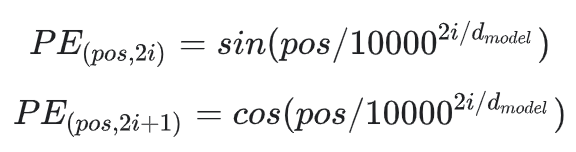

* Source: [Transformer Tutorial - Tensorflow](https://www.tensorflow.org/text/tutorials/transformer)

In [20]:
def scaled_dot_product_attention(query, key, value, attn_mask = None, dropout_p = float, is_causal = False, scale = None) -> torch.Tensor:
    # Efficient implementation equivalent to the following:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype).to(device)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal = 0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_mask.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias += attn_mask
    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim =- 1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train = True)
    return attn_weight @ value

#>> Show what happened
showC(f'{scaled_dot_product_attention} defined')

Cell complete: <function scaled_dot_product_attention at 0x7b529af23370> defined


# Attention + Multi-head

In [21]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout = 0.1):
        super().__init__()

        self.h = h
        self.d_k = d_model // h
        self.attention_heads = [nn.Linear(d_model, d_model // h).to(device) for _ in range(self.h)]

        
    def forward(self, query, key, value, attn_mask = None, dropout_p=0.0):
        attention_outputs = []
        for attention_head in self.attention_heads:
            attention_output = scaled_dot_product_attention(
                attention_head(query),
                attention_head(key),
                attention_head(value),
                attn_mask = attn_mask,
                dropout_p = dropout_p,
            )
            attention_outputs.append(attention_output)
            
        seq_len = query.size(1)
        attention_output = torch.cat(attention_outputs, dim =- 1).view(query.size(0), seq_len, d_model)
        return attention_output

![Self-Attention Diagram](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/qkv_explained-min.png)

![Components of Self-Attention](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/qkv_attention_formula-min.png)

* Source: [Sequence to Sequence (seq2seq) and Attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

# Add/Residual layer + Normalization Layer

In [22]:
def add_layer(x, y):
    """Adds two tensors together.

    Args:
    x: A torch.Tensor of shape (batch_size, seq_len, hidden_size).
    y: A torch.Tensor of the same shape as x.

    Returns:
    A torch.Tensor of the same shape as x and y, containing the sum of the two tensors.
    """

    return torch.add(x, y)

showC(f'{add_layer} defined')

Cell complete: <function add_layer at 0x7b529af22830> defined


In [23]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps = float):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

showC(f'{LayerNorm} defined')

Cell complete: <class '__main__.LayerNorm'> defined


# Position-wise Feed Forward Network

In [24]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ffn: int, dropout: float):
        """
        Args:
            d_model:      dimension of embeddings
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        self.w_1 = nn.Linear(d_model, d_ffn)
        self.w_2 = nn.Linear(d_ffn, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x:            output from attention (batch_size, seq_length, d_model)

        Returns:
            expanded-and-contracted representation (batch_size, seq_length, d_model)
        """
        
        return self.w_2(self.dropout(self.w_1(x).relu()))
    
showC(f'{PositionwiseFeedForward} defined')

Cell complete: <class '__main__.PositionwiseFeedForward'> defined


# Hyperparameters

In [25]:
# HyperParameters for the module
d_model = 300  # Should match the embedding dimension of your word embeddings
seq_len = 100  # Maximum sequence length
dropout = 0.1  # Adjust the dropout if needed

h       = 4    # number of attention head
num_heads = 4    # number of attention head

d_ffn   = 1024 # dimension of the feedforward layer
eps     = 1e-6 # epsilon value to prevent the standard deviation from becoming zero
num_classes = 5  # Replace with your number of classes
epochs = 100
learning_rate = 0.01
num_layers = 6

input_size = d_model  # Adjust this based on the output size of your feed-forward network
# input_size = len(train_data[0])  # Adjust based on your input size (should match the output size of your model)
showC('Hyperparameters defined')

Cell complete: Hyperparameters defined


In [26]:
printNv()
#print('\n\n\n\n\n\n\n\n\n\n')
#print(torch.cuda.memory_summary())

# Encoder Layer

In [27]:
class StackedEncoder(nn.Module):
    def __init__(self, num_layers, d_model, seq_len, dropout, num_heads, d_ffn):
        super(StackedEncoder, self).__init__()

        self.layers = nn.ModuleList([
            EncoderLayer(d_model, seq_len, dropout, num_heads, d_ffn) for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, seq_len, dropout, num_heads, d_ffn):
        super().__init__()

        self.positional_encoding = PositionalEncoding(d_model, dropout, seq_len)
        self.multihead_attention = MultiHeadedAttention(num_heads, d_model, dropout)
        self.norm1 = LayerNorm(d_model, eps)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ffn, dropout)
        self.norm2 = LayerNorm(d_model, eps)

    def forward(self, x):
        x_pe = self.positional_encoding(x)
        attn_output = self.multihead_attention(x_pe, x_pe, x_pe)
        x_attn = x + attn_output # Residual connection from multi-head attention
        x_norm1 = self.norm1(x_attn)
        ff_output = self.feed_forward(x_norm1)
        x_ff = x_attn + ff_output # Residual connection from feed-forward network
        x_norm2 = self.norm2(x_ff)

        return x_norm2 # Return the normalized output

showC(f'{StackedEncoder} and {EncoderLayer} defined')

Cell complete: <class '__main__.StackedEncoder'> and <class '__main__.EncoderLayer'> defined


# Encoder Test

In [28]:
###################################### TEST ##########################################
###################################### TEST ##########################################
###################################### TEST ##########################################

##################################### hyperparam #####################################
##################################### hyperparam #####################################
##################################### hyperparam #####################################

# HyperParameters for the module
d_model = 300  # Should match the embedding dimension of your word embeddings
seq_len = 100  # Maximum sequence length\ndropout = 0.1  # You can adjust the dropout if needed
h       = 4    # number of attention head\nd_ffn   = 1024 # dimension of the feedforward layer
eps     = 1e-6 # epsilon value to prevent the standard deviation from becoming zero
num_classes = 3  # Replace with your number of classes
input_size = d_model  # Adjust this based on the output size of your feed-forward network\n\n
epochs = 10
learning_rate = 0.01

## Dropout - During training, randomly zeroes some of the elements of the input
## tensor with probability p using samples from a Bernoulli distribution. Each
## channel will be zeroed out independently on every forward call.

###################################### embedding #####################################
###################################### embedding #####################################
###################################### embedding #####################################

#>> Ideally device = torch.device("cuda:0")
word_embeddings = torch.randn(32, 100, 300).to(device)

print (f"Word Embedding Shape: {word_embeddings.size}")
print (f"Word Embedding Shape: {word_embeddings.shape}")
print(f"The Word Embeddings are on: {word_embeddings.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() # !nvidia-smi
      
####################################### p.e. #########################################
####################################### p.e. #########################################
####################################### p.e. #########################################

# Instantiate the PositionalEncoding module
positional_encoder = PositionalEncoding(d_model, dropout, seq_len).to(device)

# Apply the positional encoding to your word embeddings
encoded_embeddings = positional_encoder(word_embeddings)
      
# Print the dimensions of the encoded embeddings
print(f"Encoded Embeddings Shape: {encoded_embeddings.shape}")
print(f"The Encoded Embeddings are on: {encoded_embeddings.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() # !nvidia-smi
####################################### attn ##########################################
####################################### attn ##########################################
####################################### attn ##########################################
      
# Create an instance of the MultiHeadedAttention class
multi_head_attention = MultiHeadedAttention(h, d_model, dropout).to(device)
      
# Define your query, key, and value tensors (they can be the same for self-attention)
query = encoded_embeddings.to(device)
key = encoded_embeddings.to(device)
value = encoded_embeddings.to(device)

print(f"The Query Tensor is on: {query.device}")
print(f"The Key Tensor is on: {key.device}")
print(f"The Value Tensor is on: {value.device}")

# Optional: Define an attention mask or use None if not needed
attn_mask = None

# Apply the MultiHeadedAttention\n
attention_output = multi_head_attention(query, key, value, attn_mask = attn_mask)

# Print the dimensions of the attention output\n
print(f"Attention Output Shape: {attention_output.shape}")
print(f"The Attention Output is on: {attention_output.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() # !nvidia-smi
######################################## add ##########################################
######################################## add ##########################################
######################################## add ##########################################

residual_connection = add_layer(attention_output, encoded_embeddings)

print(f"Residual Connection Shape: {residual_connection.shape}")
print(f"The Residual Connection is on: {residual_connection.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() # !nvidia-smi

######################################## norm #########################################
######################################## norm #########################################
######################################## norm #########################################

norm = LayerNorm(d_model, eps).to(device)
normalized_values = norm(residual_connection)
      
print(f"Normalized Values Shape: {normalized_values.shape}")
print(f"The Normalized Values are on: {normalized_values.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() # !nvidia-smi() 

######################################## fc ##########################################
######################################## fc ##########################################
######################################## fc ##########################################
      
feedforward = PositionwiseFeedForward(d_model, d_ffn, dropout).to(device)
ff_output = feedforward(normalized_values)

print(f"FF Output Shape: {ff_output.shape}")
print(f"The Output is on: {ff_output.device}")
print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() #!nvidia-smi
showC('Encoder test')

Word Embedding Shape: <built-in method size of Tensor object at 0x7b529af26160>
Word Embedding Shape: torch.Size([32, 100, 300])
The Word Embeddings are on: cpu
Total allocated memory: 0 bytes
Encoded Embeddings Shape: torch.Size([32, 100, 300])
The Encoded Embeddings are on: cpu
Total allocated memory: 0 bytes
The Query Tensor is on: cpu
The Key Tensor is on: cpu
The Value Tensor is on: cpu
Attention Output Shape: torch.Size([32, 100, 300])
The Attention Output is on: cpu
Total allocated memory: 0 bytes
Residual Connection Shape: torch.Size([32, 100, 300])
The Residual Connection is on: cpu
Total allocated memory: 0 bytes
Normalized Values Shape: torch.Size([32, 100, 300])
The Normalized Values are on: cpu
Total allocated memory: 0 bytes
FF Output Shape: torch.Size([32, 100, 300])
The Output is on: cpu
Total allocated memory: 0 bytes
Cell complete: Encoder test


**We can now split our dataset into training and validation sets. When working on machine learning or deep learning models, we want to train the model on a subset of the data, and then test the accuracy of the model's predictions on the remaining data. This is called data splitting. We typically split the data into an 80/20 split, where we train the model on 80% of the data and test it on the remaining 20%.**

In [29]:
printNv() # #!nvidia-smi
printM()   #print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")

#print('\n\n\n\n\n\n\n\n\n\n')
#print(torch.cuda.memory_summary())

Total allocated memory: 0 bytes


In [30]:
stacked_encoder = StackedEncoder(num_layers, d_model, 
                                 seq_len, dropout, num_heads, d_ffn).to(device)

In [31]:
printNv()#!nvidia-smi
#print('\n\n\n\n\n\n\n\n\n\n')
#print(torch.cuda.memory_summary())

In [32]:
# DataLoader
#>> dataset = TensorDataset(text_embeddings_tensors, rating_labels_tensors)
data_loader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [ ]:
total_encoded_batches = []  # List to store encoded batches
total_y_batches = []        # List to store corresponding y batches
i = 0

for x_batch, y_batch in data_loader:
    #>> regrouped for loop display logic
    if i == 0:
        printd(f'Size of x_batch: {x_batch.shape}')
        printd(f'Size of y_batch: {y_batch.shape}')
    if i % 20 == 0:
        printv(f'{i} batches processed')
        printM()
    i += 1
    
    # Move the batch to the device
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    
    # Encode the batch using the stacked_encoder
    encoded_batch = stacked_encoder(x_batch)
    
    # Append the encoded batch to the list
    #>> detach removes gradient computed by encoder
    total_encoded_batches.append(encoded_batch.detach().cpu())
    total_y_batches.append(y_batch.detach().cpu())
    
    if i % 20 == 1:
        printd(f'Current Size of Reviews: {len(total_encoded_batches)} tensors')
        printd(f'Current Size of Ratings: {len(total_y_batches)} tensors')

printv(f'{i} batches processed')
printM()

# Concatenate all the encoded batches into a single tensor
total_encoded_batch = torch.cat(total_encoded_batches, dim = 0)

# Concatenate all the corresponding y batches into a single tensor
total_y_batch = torch.cat(total_y_batches, dim = 0)

printv(f'Concatenated Reviews Size: {total_encoded_batch.shape}')
printv(f'Concatenated Ratings Size: {total_y_batch.shape}')

showC('Batch encodings')


DEV: Size of x_batch: torch.Size([32, 1347, 300])
DEV: Size of y_batch: torch.Size([32])
VERBOSE: 0 batches processed
Total allocated memory: 0 bytes
DEV: Current Size of Reviews: 1 tensors
DEV: Current Size of Ratings: 1 tensors


In [ ]:
'''
total_encoded_batch = [] 
total_y_batch = [] 
i = 0

for x_batch, y_batch in data_loader:  # Iterate over the training batches
     print(f'size of batch: {x_batch.shape}')
     i = i + 1
    
     print(i)
     print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
    
     !nvidia-smi
     print('\n\n')
    
     x_batch_encoded = stacked_encoder(x_batch).to(device)  # Encode the reviews using the stacked encoder
    
     total_encoded_batch.append(x_batch_encoded)
     total_y_batch.append(y_batch)

total_encoded_batch = torch.cat(total_encoded_batch, dim = 0)  # Concatenate all the encoded batches into a single tensor
total_y_batch = torch.cat(total_y_batch)
showC('Batch encodings')
'''

In [ ]:
print(total_encoded_batch.shape)  # Check the shape of the combined encoded tensor
print(total_y_batch.shape)
print('\n')
print(f"The Encoded batch is on: {total_encoded_batch.device}")
print(f"The Y batch is on: {total_y_batch.device}")
print('\n')
# print(stacked_encoder)
print('\n')


# size in MB
print(f'x_batch size: { total_encoded_batch.nelement() * total_encoded_batch.element_size() }')
print(f'y_batch size: { total_y_batch.nelement() * total_y_batch.element_size() }')

In [ ]:
#del dataset
#torch.cuda.empty_cache()

#!nvidia-smi
#print(torch.cuda.memory_summary())

#print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
#print('\n\n\n\n\n\n\n\n\n\n')
#print(torch.cuda.memory_summary())

In [ ]:
# Duplicates previous cell
'''
print(total_encoded_batch.shape)  # Check the shape of the combined encoded tensor
print(total_y_batch.shape)
print('\n')
print(f"The Encoded batch is on: {total_encoded_batch.device}")
print(f"The Y batch is on: {total_y_batch.device}")
'''

### Realized that I was spliting the data before encoding and thus the training data was only being encoded. Might also explain why the validation score was so low (along with how small the dataset is and how the large epochs are definitely overfitting)

In [ ]:
# Lengths 
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len

# Random split
train_data, val_data = random_split(dataset, [train_len, val_len])

printv(f"The amount of data we have to train with is {len(train_data)} revieww") 
printv(f"The amount of data we have to validate with is {len(val_data)} reviews")
#print(f"The amount of data we have to validate with is on {train_data.device}")
#print(f"The amount of data we have to validate with is on {val_data.device}")

# DataLoader for training data
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)  # Use shuffle for training

# DataLoader for validation data
val_loader = DataLoader(val_data, batch_size = 32, shuffle = False)  # No need to shuffle for validation

### Moved input_size here

In [ ]:
# new dataset object post encoding
#encoded_training_dataset = TensorDataset(total_encoded_batch, total_y_batch)

# Print the sliced dataset
#print(encoded_review_dataset[:5])

# Should match the output size of your model
#input_size = len(train_data[0])

In [ ]:
printM() # print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() #!nvidia-smi
#print('\n\n\n\n\n\n\n\n\n\n')
#print(torch.cuda.memory_summary())

## Classifier

In [ ]:
class Classifier(nn.Module):
    def __init__(self, r_size,v_size, num_classes):
        # r_size is the number of tokens in a review, 100.
        # v_size is the number of values in an embedding vector, 300.
        super(Classifier, self).__init__()
        
        # The input to fc will be a 2D tensor with with n rows and
        # r_size * v_size columns, where n >= 1; and the output will be a 2D tensor
        # with n rows and num_classes columns.
        self.fc = nn.Linear(r_size * v_size, num_classes)

    def forward(self, x1):
        # Pass input through the linear layer
        return self.fc(x1)
    
showC(f'{Classifier} defined')

In [ ]:
#>> why define classifier twice?
class Classifier(nn.Module):
    def __init__(self, r_size,v_size, num_classes):
        # r_size is the number of tokens in a review, 100.
        # v_size is the number of values in an embedding vector, 300.
        super(Classifier, self).__init__()
        
        # The input to fc will be a 2D tensor with with n rows and
        # r_size * v_size columns, where n >= 1; and the output will be a 2D tensor
        # with n rows and num_classes columns.
        self.fc = nn.Linear(r_size * v_size, num_classes)

    def forward(self, x1):
        # Pass input through the linear layer
        return self.fc(x1)

# Create the classifier
classifier = Classifier(seq_len, d_model, num_classes + 1).to(device)

showC(f'{Classifier} defined')

In [ ]:
printM() # print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() # !nvidia-smi
#print('\n\n\n\n\n\n\n\n\n\n')
#print(torch.cuda.memory_summary())

### Changing reshaping format to check on the input size. Hardcoding the reshaping dimensions as 32 was breaking the classifier (presumably due to the data not being perfectly divisible by 32)
### Moved the hyperparameters a few cells up where the encoder's hyperparameters were since they were similar

In [ ]:
# Define Cross-Entropy loss
criterion = nn.CrossEntropyLoss() # nn.CategoricalCrossentropy() #nn.Softmax() 

# Define SGD optimizer
# Is Adam better?
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

DEV = True
# Training loop (adjust this to match your data and DataLoader)
for epoch in range(epochs):
    for inputs, targets in train_loader :  # Assuming you have a DataLoader
        # for batch_data in train_loader:  # Assuming you have a DataLoader
        # inputs, targets = batch_data  # Assuming your DataLoader provides input data and targets    
    
        #printd(f'inputs shape: {inputs.shape}')
        #printd(f'targets shape: {targets.shape}')
        #printd(f'targets: {targets}')

        optimizer.zero_grad()
    
        # keep nn.linear happy by combining the last two dimensions of inputs.
        inputs = torch.reshape(inputs, (inputs.size(0), -1)) # get current batch size
        #inputs = torch.reshape(inputs, (32,30000))
        
        #printd(f'Reshaped inputs: {inputs.shape}')
        
        outputs = classifier(inputs)
        #printd(f'outputs shape {outputs.shape}')
        
        # output is a 32 x 6 tensor of floats,
        # targets will be a 32 x 1 tensor of ints
        loss = criterion(outputs, targets)
        # print(f'loss.item: {loss.item()}')
        loss.backward(retain_graph=True)
        optimizer.step()
     
    print(f'Epoch [{epoch+1}/{epochs}] Loss: {loss.item()}')
    
showC(f'training complete')

In [ ]:
printM() #>> print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
print(Nv() #>> !nvidia-smi
#print('\n\n\n\n\n\n\n\n\n\n')
print(torch.cuda.memory_summary())

In [ ]:
# Put model in evaluation mode
classifier.eval() 

# Tracking variables
predictions = []
actuals = []

# Evaluate on validation set
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.reshape(inputs.shape[0], -1)
        
        outputs = classifier(inputs)
        _, predicted = torch.max(outputs, 1)
        
        predictions.extend(predicted.tolist())
        actuals.extend(targets.tolist())
        
# Print sample outputs        
print("Predicted | Actual")
for i in range (60):
    print(f"{predictions[i]} | {actuals[i]}")
    
# Calculate validation accuracy
num_correct = sum([p == a for p, a in zip(predictions, actuals)]) 
val_accuracy = num_correct / len(predictions)
print(f'Validation Accuracy: {val_accuracy:.2f}')

showC('validate')

In [ ]:
print(total_encoded_batch.device)
print(total_y_batch.device)

print(stacked_encoder)
print(classifier)

print(f'x_batch: { total_encoded_batch.nelement() * total_encoded_batch.element_size() }')
print(f'y_batch: { total_y_batch.nelement() * total_y_batch.element_size() }')

In [ ]:
import sys 

# Stacked Encoder 
for name, param in stacked_encoder.named_parameters():
    print(f"{name}:\t{sys.getsizeof(param.untyped_storage()) / 1e6:.2f} MB")

# Classifier 
for name, param in classifier.named_parameters():
    print(f"{name}:\t{sys.getsizeof(param.untyped_storage()) / 1e6:.2f} MB")
    

del dataset
torch.cuda.empty_cache()

printNv() # !nvidia-smi
printM() # print(torch.cuda.memory_summary())

## Try and print every utilization of .to(device) to try and see what'son the gpu

In [ ]:
# attention components
#self.attention_heads
#print(attn_bias.device)

# pre-processed input tensors
print(text_embeddings_tensors.device)
print(f'text_embeddings: { text_embeddings_tensors.nelement() * text_embeddings_tensors.element_size() }')
print(rating_labels_tensors.device)
print(f'rating_labels: { rating_labels_tensors.nelement() * rating_labels_tensors.element_size() }')

#tensor object
#print(dataset)

# processed input tensor
print(total_encoded_batch.device)
print(f'total_encoded_batch: { total_encoded_batch.nelement() * total_encoded_batch.element_size() }')
print(total_y_batch.device)
print(f'y_batch: { total_y_batch.nelement() * total_y_batch.element_size() }')

# moedels
#print(stacked_encoder.device)
#print(classifier.device)

class Classifier(nn.Module):
    def __init__(self, r_size,v_size, num_classes):
        # r_size is the number of tokens in a review, 100.
        # v_size is the number of values in an embedding vector, 300.
        super(Classifier, self).__init__()
        
        # The input to fc will be a 2D tensor with with n rows and
        # r_size * v_size columns, where n >= 1; and the output will be a 2D tensor
        # with n rows and num_classes columns.
        self.fc = nn.Linear(r_size * v_size, num_classes)

    def forward(self, x1):
        # Pass input through the linear layer
        return self.fc(x1)

# The next two lines were an attempt to fix the obscure CUDA assert error --
# didn't work. But there's a workaround, just run without the accelerator.
# You can get away with that if you just have 5,000 reviews in each category.
#
CUDA_LAUNCH_BLOCKING=1 
TORCH_USE_CUDA_DSA=1

# Create the classifier
classifier = Classifier(seq_len, d_model, num_classes+1)#.to(device)

# Define Cross-Entropy loss
criterion = nn.CrossEntropyLoss() # nn.CategoricalCrossentropy() #nn.Softmax() 

# Define SGD optimizer
# Is Adam better?
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

# DEV = True
# Training loop (adjust this to match your data and DataLoader)
for epoch in range(epochs):
    for x_batch, y_batch in encoded_review_dataset:  # Assuming you have a DataLoader
        inputs, targets = x_batch, y_batch  # Assuming your DataLoader provides input data and targets
       
        printd(f'targets shape: {targets.shape}')
        printd(f'targets: {targets}')
        printd(f'inputs shape: {inputs.shape}')
        printd(f'inputs: {inputs}')

        optimizer.zero_grad()
    
        # keep nn.linear happy by combining the last two dimensions of inputs.
        #
        inputs = torch.reshape(inputs, (32,30000))
        printd(f'Reshaped inputs: {inputs.shape}')
        
        outputs = classifier(inputs)
        printd(f'outputs shape {outputs.shape}')
        
        #dummy_output = torch.randn(32, 5, requires_grad=True).to(device)
        # printd(f'dummy_output shape {dummy_output.shape}')
        # printd(f'dummy_output {dummy_output}')
        # output should be a 32 x 5 tensor of floats,
        # targets will be a 32 x 1 tensor of ints
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}] Loss: {loss.item()}')
    
DEV = False

# Define the Classifier class
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        
        self.linear_1 = nn.Linear(input_size, num_classes)
        self.linear_2 = nn.Linear(1, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1):
        
        linear_1_output = self.linear_1(x_batch)
        linear_2_output = self.linear_2(y_batch)
        combined_output = linear_1_output + linear_2_output
        output = self.sigmoid(combined_output)
        
        return output
    
# Create the classifier
classifier = Classifier(input_size, num_classes)#.to(device)

# Define Cross-Entropy loss
criterion = nn.CrossEntropyLoss()

# Define SGD optimizer for both classifier
optimizer = optim.SGD(list(classifier.parameters()), lr = learning_rate)

# Training loop (adjust this to match your data and DataLoader)
for epoch in range(epochs):
    for batch_data in :  # Assuming you have a DataLoader
        inputs, targets = x_batch, y_batch  # Assuming your DataLoader provides input data and targets
        optimizer.zero_grad()
        
        outputs = classifier()  
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{epochs}] Loss: {loss.item()}')

You can think of the loss function as the valley, with the steepest parts being where the loss is highest and the flatter parts being where the loss is lower. The hiker is the set of model parameters, which are being updated with each step (iteration). SGD is like the GPS for the hiker, helping it navigate toward the lowest point in the valley (i.e. the global minimum of the loss function) with each step. The key difference is that SGD is an iterative process that updates the parameters in small steps, rather than finding the global minimum in a single shot. The learning rate is essentially the "speed limit" for the hiker (the model parameters). The learning rate would be how far the GPS would tell the hiker to go before it iterates/updates. A higher learning rate means that the hiker can make larger updates to the parameters with each step, while a lower learning rate means that the updates are smaller. This is important because it determines not only how quickly the model can find the global minimum, but also how stable the descent is - if the learning rate is too high, the hiker could get lost in the valley, but if it's too low, it could take forever to reach the bottom. So, the learning rate controls the speed of the descent and helps the model find the optimal set of parameters without overshooting or taking too long.

Some additional points to augment the analogy:

The terrain can be rugged with many hills, valleys, and obstacles - like the high-dimensional, non-convex loss function landscape.

Momentum in SGD helps the hiker build up speed in consistently downhill directions, like momentum in GD.

Adaptive LR is like the GPS dynamically recommending faster or slower speeds depending on terrain.

Regularization is like constraining the hiker's path to stay on trails and avoid dangerous cliffs (to prevent overfitting).

Batch size is like the number of hikers traversing together (to average gradient noise).

Epochs are like hiking to the bottom, then restarting from the top to repeat the descent.

Early stopping is like stopping the hike once you reach a good enough point close to the valley floor.

Hyperparameter tuning is like tweaking the GPS settings for optimal navigation.

Vanishing gradients are like certain paths becoming too steep or hitting dead-ends.

Local minima: The terrain can be rugged with many local minima, which are small valleys that are not as deep as the global minimum. SGD can get stuck in local minima, but there are various techniques that can help to avoid this, such as momentum and adaptive learning rate.

Learning rate schedule: The learning rate can be adjusted over time to improve the performance of SGD. This is known as a learning rate schedule. For example, the learning rate can be decreased as the model converges to the global minimum, in order to prevent overshooting.

Noise: The gradient calculation can be noisy, especially when the batch size is small. This can cause SGD to take a more erratic path towards the global minimum. However, the noise can be averaged out by using a larger batch size.